In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#import warnings
#warnings.filterwarnings('ignore')

import time
import threading

import numpy as np
import pandas as pd
from scipy.linalg import solve

import streamz as sz

from IPython.display import display, Markdown
from bokeh.models.widgets import HTMLTemplateFormatter
import param
import holoviews as hv; hv.extension("bokeh", logo=False)
import panel as pn;     pn.extension()

from holoviews.streams import Buffer

<div style="float:center;width:100%;text-align: center;"><strong style="height:60px;color:darkred;font-size:40px;">Iterative Methods with Python</strong></div>

# 1. Code: Monitor the Evolution of an Iterative Scheme

In [2]:
def _table_formatter2D(plot, element):
    plot.handles['table'].columns[3].formatter = HTMLTemplateFormatter(
        template = """<div style="color:red;"><%= value ? value.toExponential(4) : value %></div>""")
def _table_formatterND(plot, element):
    plot.handles['table'].columns[2].formatter = HTMLTemplateFormatter(
        template = """<div style="color:red;"><%= value ? value.toExponential(4) : value %></div>""")

class GraphicalMonitor2D:
    """monitor the error evolution of an iterative scheme"""

    def __init__(self, sz=10, use_log=False):
        self.buffer  = hv.streams.Buffer(self._to_dataframe(), length=sz, index=False)
        self.use_log = use_log

        self.plots = pn.Column( pn.Row( hv.DynamicMap(self.display_xy,  streams=[self.buffer]),
                                        hv.DynamicMap(self.display_err, streams=[self.buffer])
                                      ),
                                 hv.DynamicMap(self.display_tbl, streams=[self.buffer])
                            )
    def _to_dataframe(self, data=None):
        data_def = {"step": int, "x": float, "y": float, "error": float}

        if data is None:
            return pd.DataFrame(
                {i: [] for i in data_def},
            ).astype(dtype=data_def)

        return pd.DataFrame([data], columns=data_def).astype(dtype=data_def)

    def reset_plots(self):
        self.buffer.clear()

    def monitor(self, data):
        self.buffer.send(self._to_dataframe(data))

    def display_xy(self, data):
        if data.empty:
            return ( hv.Scatter([], "x", "y") * hv.Curve([], "x", "y")  * hv.Scatter([], "x", "y")
                    ).opts( width=500,  xticks=4, yticks=4, tools=["hover"], show_grid=True, title="Solution Estimate" )
        h_last_point = hv.Scatter( (data["x"].iloc[-1], data["y"].iloc[-1]), "x", "y" ).opts(size=10, color="red", tools=["hover"])

        h_points = hv.Curve((data["x"], data["y"]), "x", "y") *\
                   hv.Scatter( (data["x"], data["y"]), "x", "y" )\
                     .opts(color="darkblue", padding=0.05, size=8, tools=["hover"], show_grid=True)

        return (h_points.opts(xticks=4, yticks=4) * h_last_point).opts(width=500, tools=["hover"])

    def display_err( self, data):
        edim = hv.Dimension('error', range=(1e-18, np.nan))
        if data.empty:
            return hv.Curve([], "step", edim).opts( tools=["hover"], logy=self.use_log, yticks=4, show_grid=True, title="Error" )
        return hv.Curve((data["step"], data["error"]), "step", edim).opts(padding=0.05, xticks=4, logy=self.use_log)

    def display_tbl( self, data ):
        if data.empty:
            return hv.Table(data).opts(height=450,width=500, hooks=[_table_formatter2D])
        return hv.Table(data).opts(hooks=[_table_formatter2D])

class GraphicalMonitorND:
    """monitor the error evolution of an iterative scheme"""

    def __init__(self, dimension, sz=10, use_log=False):
        self._data_def = {"step": int}
        for i in range(dimension):
            self._data_def['x'+ str(i+1)] = float
        self._data_def["error"] = float

        self.buffer  = hv.streams.Buffer(self._to_dataframe(), length=sz, index=False)
        self.use_log = use_log

        self.plots = pn.Row( hv.DynamicMap(self.display_err, streams=[self.buffer]),
                             hv.DynamicMap(self.display_tbl, streams=[self.buffer]) )

    def _to_dataframe(self, data=None):
        if data is None:
            return pd.DataFrame(
                    {i: [] for i in self._data_def},
                ).astype(dtype= self._data_def)

        flattend_data = [data[0]] + data[1].tolist() + [data[2]]
        return pd.DataFrame([flattend_data], columns=self._data_def).astype(dtype=self._data_def)

    def reset_plots(self):
        self.buffer.clear()

    def monitor(self, data):
        self.buffer.send(self._to_dataframe(data))

    def display_err( self, data):
        edim = hv.Dimension('error', range=(1e-18, np.nan))
        if data.empty:
            return hv.Curve([], "step", edim).opts(  logy=self.use_log, tools=["hover"], yticks=4, show_grid=True, title="Error" )
        return hv.Curve((data["step"], data["error"]), "step", edim).opts(padding=0.05, xticks=4, logy=self.use_log, tools=["hover"])

    def display_tbl( self, data ):
        if data.empty:
            return hv.Table(data).opts(height=450,width=500, hooks=[_table_formatterND])
        return hv.Table(data).opts(hooks=[_table_formatterND])

# 2. Iterative Solutions of $\mathbf{A x = b}$

## 2.1 Idea: Set up a Fixed Point

**Wanted:** an iterative scheme to solve $A x = b$ for a square matrix $A$.

We split $A = S - T$ such that $S$ is invertible:

$\qquad \begin{align}
\color{blue}{\mathbf{A x = b}}   & \Leftrightarrow ( S - T )\ x = b \\
          & \Leftrightarrow S x = T x + b \\
          & \Leftrightarrow x = S^{-1} T x + S^{-1} b \\
          & \Leftrightarrow \color{blue}{\mathbf{x = \tilde{A}x + \tilde{b}}}
\end{align},$<br><br>
$\qquad$ where we have set $\tilde{A} = S^{-1} T, \;\; \tilde{b} = S^{-1} b.$

Convert this last equation into an iteration:<br>
$\qquad$ Start with some vector $x_0$, and compute
$\qquad \color{blue}{\mathbf{x_{n} = \tilde{A} x_{n-1} + \tilde{b}, \quad n=1,2,\dots}}$

The difference between successive iterates is $\qquad\;\; \color{blue}{\mathbf{e_{n} = x_n - x_{n-1}}}$.

When $\color{blue}{\mathbf{\underset{\mathbf{n \to \infty}}{\operatorname{\lim}} e_{n} = 0}}$, the iterative converges to a **fixed point**, a solution of $A x = b$

#### **Example**

> Consider $\begin{pmatrix} x_n \\ y_n \end{pmatrix} =  \begin{pmatrix}  0.4 & -0.1 \\ 0.2 & 0.1 \end{pmatrix}
\begin{pmatrix} x_{n-1} \\ y_{n-1} \end{pmatrix} + \begin{pmatrix} 0.8 \\ 1.6 \end{pmatrix},
\qquad \text{with} \quad \begin{pmatrix}x_0 \\ y_0 \end{pmatrix} = \begin{pmatrix} 3 \\ 1 \end{pmatrix}$

> A fixed point satisfies<br>
$\quad \begin{pmatrix} x \\ y \end{pmatrix} =  \begin{pmatrix}  0.4 & -0.1 \\ 0.2 & 0.1 \end{pmatrix}
\begin{pmatrix} x \\ y \end{pmatrix} + \begin{pmatrix} 0.8 \\ 1.6 \end{pmatrix}
\quad \Leftrightarrow \quad
\begin{pmatrix} 0.6 & 0.1 \\ -0.2 & 0.9 \end{pmatrix} 
\begin{pmatrix} x \\ y \end{pmatrix} =
\begin{pmatrix} 0.8 \\ 1.6 \end{pmatrix}
$

In [3]:
def iterate_scheme( A, b, x, n, plots, tol=1.e-10 ):
    plots.reset_plots()

    errs = []

    twoD = A.shape[1] == 2
    if twoD:
        print( " Iteration\t\t x \t          y \t\t Error")
    else:
        print( " Iteration\t\t x \t          y \t          z \t\t Error")

    for i in range(n):
        x_old = x
        x     = A @ x + b
        err   = np.linalg.norm( x-x_old )

        errs.append( err )
        if twoD:
            print( f"{i:10}\t {x[0]: .10f}\t   {x[1]: .10f}\t{err: .10f}" )
            plots.monitor( [i, x[0], x[1], err] )
        else:
            with np.printoptions(formatter={'float': '{: 0.10f}'.format}):
                print( f"{i:10}\t {x}\t{err: .10f}" )
            plots.monitor( [i, x, err] )

        if err < tol:
            return x, err, errs
        time.sleep(0.5)
    return None,err,errs

## 2.2 Convergence

Given a scheme $x_n = A x_{n-1} + b$ with some initial guess $x_0$,<br>
$\qquad$ when does it converge?

Let's look at the change at each iteration step: $e_n = x_{n} - x_{n-1}$.<br>
$\qquad$ Starting with $n = 1,$ we see<br>
$\qquad\quad\begin{align}
e_2 &= \left(A x_1 + b \right) - \left( A x_0 + b \right) &= A e_1 & \\
e_3 &= \left(A x_2 + b \right) - \left( A x_1 + b \right) &= A e_2 & = A^2 e_1 \\
\dots & & & \\
e_{n+1} &= \left(A x_{n} + b \right) - \left( A x_{n-1} + b \right) &= A e_n & = A^{n} e_1 \\
\end{align}$

When $A = S \Lambda S^{-1}$, we obtain<br><br>
$\qquad
\mathbf{\underset{\mathbf{n \to \infty}}{\operatorname{\lim}}} e_{n+1} =
S \ \begin{pmatrix}
      \mathbf{\underset{\mathbf{n \to \infty}}{\operatorname{\lim}}} \lambda^n_1 & 0 & \dots & 0 \\
  0 & \mathbf{\underset{\mathbf{n \to \infty}}{\operatorname{\lim}}} \lambda^n_2     & \dots & 0 \\
    &                                                                           &   & \dots &   \\
  0 & 0 & \dots & \mathbf{\underset{\mathbf{n \to \infty}}{\operatorname{\lim}}} \lambda^n_N \\
\end{pmatrix}\ S^{-1}
$

We see that this limit goes to zero iff $\lvert \lambda_i \rvert < 1$ for each $i=1,2, \dots N$.

<div style="float:left;padding-left:5pt;width:98%;background-color:#F2F5A9;color:black;">

**Definition:** The **spectral radius** of a matrix $A$ of size $N \times N$ is given by<br>
$\qquad \rho(A) = \underset{\mathbf{i=1,2,\dots N}}{\operatorname{\max}}\ \lvert \lambda_i \rvert$

**Theorem:** the iteraitve scheme $x_n = A x_{n-1} + b$ converges iff $\rho (A) < 1$.
</div>

## 2.3 Jacobi Iteration

Let $A = S - T, $ where $S$ is the diagonal matrix $S_{i i} = A_{i i}, i=1, \dots N$ (the diagonal entries of $A$)

Then $A x = b \Leftrightarrow S x = T x + b \Leftrightarrow x = S^{-1} T x + S^{-1} b$

In [4]:
A = np.array([[6., .1], [-.2, .9]]); b = np.array([0.8,1.6])
S = np.diag( np.diag(A) )
T = S - A
"A =";A
"b =";b

"S =";S

'A ='

array([[ 6. ,  0.1],
       [-0.2,  0.9]])

'b ='

array([0.8, 1.6])

'S ='

array([[6. , 0. ],
       [0. , 0.9]])

In [5]:
Sinv = np.linalg.inv(S)
SinvT = Sinv @ T
Sinvb = Sinv @ b

Markdown('**<font size="5">Jacobi Iteration, 2D Example**</font>')
plots = GraphicalMonitor2D(100,use_log=False)
plots.plots
x,err,errs = iterate_scheme( SinvT, Sinvb, np.array([3,-2]),  100, plots, tol=1e-8 )

**<font size="5">Jacobi Iteration, 2D Example**</font>

Column
    [0] Row
        [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', width=500)
        [1] HoloViews(DynamicMap, height=300, sizing_mode='fixed', width=300)
    [1] HoloViews(DynamicMap, height=450, width=500)

 Iteration		 x 	          y 		 Error
         0	  0.1666666667	    2.4444444444	 5.2707555623
         1	  0.0925925926	    1.8148148148	 0.6339719544
         2	  0.1030864198	    1.7983539095	 0.0195213169
         3	  0.1033607682	    1.8006858711	 0.0023480443
         4	  0.1033219021	    1.8007468374	 0.0000723012
         5	  0.1033208860	    1.8007382005	 0.0000086965
         6	  0.1033210300	    1.8007379747	 0.0000002678
         7	  0.1033210338	    1.8007380067	 0.0000000322
         8	  0.1033210332	    1.8007380075	 0.0000000010


In [6]:
A     = np.array([[ 6., 2, -3],
                  [-1., 3,  1],
                  [ 1., 2,  4]])
b = np.array([1., 1, 1])

S     = np.diag( np.diag(A) )
T     = S - A
Sinv  = np.linalg.inv(S)    # Note:  In our iteration, solve  S x_n = T x_{n-1} + b   for x_n  instead!!!!

SinvT = Sinv @ T
Sinvb = Sinv @ b

In [7]:
eigA  = np.linalg.eigvals(SinvT)
print("Spectral Radius: ")
print(".  eigenvalues: ", np.round( eigA, 3) )
print(".  max(abs(e)): ", np.round(max(np.abs(eigA)),3))

Spectral Radius: 
.  eigenvalues:  [ 0.216+0.458j  0.216-0.458j -0.433+0.j   ]
.  max(abs(e)):  0.507


In [8]:
plots = GraphicalMonitorND(3,10,use_log=False)
Markdown('**<font size="5">Jacobi Iteration, 3D Example**</font>')

plots.plots
x,err,errsJ = iterate_scheme( SinvT, Sinvb, np.array([3,-2,1]), 100, plots, tol=1e-8 )

**<font size="5">Jacobi Iteration, 3D Example**</font>

Row
    [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', width=300)
    [1] HoloViews(DynamicMap, height=450, width=500)

 Iteration		 x 	          y 	          z 		 Error
         0	 [ 1.3333333333  1.0000000000  0.5000000000]	 3.4681086744
         1	 [ 0.0833333333  0.6111111111 -0.5833333333]	 1.6992191380
         2	 [-0.3287037037  0.5555555556 -0.0763888889]	 0.6556322211
         3	 [-0.0567129630  0.2492283951  0.0543981481]	 0.4300238846
         4	 [ 0.1107896091  0.2962962963  0.1395640432]	 0.1937155870
         5	 [ 0.1376832562  0.3237418553  0.0741544496]	 0.0758613334
         6	 [ 0.0958299397  0.3545096022  0.0537082583]	 0.0558247354
         7	 [ 0.0753509284  0.3473738938  0.0487877140]	 0.0222378055
         8	 [ 0.0752692257  0.3421877381  0.0574753210]	 0.0101181718
         9	 [ 0.0813417478  0.3392646349  0.0600888245]	 0.0072284478
        10	 [ 0.0836228673  0.3404176411  0.0600322456]	 0.0025565857
        11	 [ 0.0832102424  0.3411968739  0.0588854626]	 0.0014465733
        12	 [ 0.0823771067  0.3414415933  0.0585990024]	 0.0009143644
        13	 [ 0.0821523035  0.3412593681

## 2.4 Gauss Seidel Iteration (GS)

**Idea:** Consider an iterative scheme<br>
$\qquad\begin{align}
x_{n} &=\;\; 4 \ x_{n-1} &+ 4 \ &y_{n-1} &+ 3 \ &z_{n-1} &+ 2 \\
y_{n} &=\;\; 2 \ x_{n-1} &- 2 \ &y_{n-1} &- 3 \ &z_{n-1} &- 1 \\
z_{n} &=\;\; 3 \ x_{n-1} &- 3 \ &y_{n-1} &+ 3 \ &z_{n-1} &+ 1 \\
\end{align}$

why not use the updated versions of $x_{n}, y_{n}$ as soon as they become available?<br>
$\qquad\begin{align}
x_{n} &= \;\; 4\ x_{n-1}            &+ 4 \ &y_{n-1}            &+ 3 \ &z_{n-1} &+ 2 \\
y_{n} &= \;\; 2\ x_{\color{red}{n}} &- 2 \ &y_{n-1}            &- 3 \ &z_{n-1} &- 1 \\
z_{n} &= \;\; 3\ x_{\color{red}{n}} &- 3 \ &y_{\color{red}{n}} &+ 3 \ &z_{n-1} &+ 1 \\
\end{align}$

**This corresponds to choosing $\mathbf{S}$ to be the <font color="red">lower triangular part of $\mathbf{A}$.</font>**

In [9]:
S     = np.tril(A)
T     = S - A
Sinv  = np.linalg.inv(S)    # Note:  In our iteration, solve  S x_n = T x_{n-1} + b   for x_n  instead!!!!

SinvT = Sinv @ T
Sinvb = Sinv @ b

eigA  = np.linalg.eigvals(SinvT)
print("Spectral Radius: ")
print(".  eigenvalues: ", np.round(eigA,3) )
print(".  max(abs(e)): ", np.round( max(np.abs(eigA)),3 ))

Spectral Radius: 
.  eigenvalues:  [ 0.   +0.j    -0.076+0.148j -0.076-0.148j]
.  max(abs(e)):  0.167


In [10]:
plots = GraphicalMonitorND(3,10,use_log=False)
Markdown('**<font size="5">Gauss Seidel Iteration**</font>')

plots.plots
x,errGS,errsGS = iterate_scheme( SinvT, Sinvb, np.array([3,-2,1]), 100, plots, tol=1e-8 )

**<font size="5">Gauss Seidel Iteration**</font>

Row
    [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', width=300)
    [1] HoloViews(DynamicMap, height=450, width=500)

 Iteration		 x 	          y 	          z 		 Error
         0	 [ 1.3333333333  0.4444444444 -0.3055555556]	 3.2338153516
         1	 [-0.1342592593  0.3904320988  0.0883487654]	 1.5204953027
         2	 [ 0.0806970165  0.3307827503  0.0644343707]	 0.2243571784
         3	 [ 0.0886229352  0.3413961882  0.0571461721]	 0.0151189646
         4	 [ 0.0814410233  0.3414316171  0.0589239356]	 0.0073987538
         5	 [ 0.0823180955  0.3411313866  0.0588547828]	 0.0009296107
         6	 [ 0.0823835959  0.3411762710  0.0588159655]	 0.0000883838
         7	 [ 0.0823492258  0.3411777534  0.0588238169]	 0.0000352866
         8	 [ 0.0823526573  0.3411762801  0.0588236956]	 0.0000037364
         9	 [ 0.0823530878  0.3411764640  0.0588234960]	 0.0000005089
        10	 [ 0.0823529267  0.3411764769  0.0588235299]	 0.0000001651
        11	 [ 0.0823529393  0.3411764698  0.0588235303]	 0.0000000145
        12	 [ 0.0823529419  0.3411764705  0.0588235293]	 0.0000000028


## 2.5 Successive Overrelaxation (SOR)

**Idea:** A step of the Gauss-Seidel scheme moves the solution estimate form $x_{n-1}$ to $x_n$.<br>
$\quad$ How about moving by a different amount, i.e., for $x_{n-1}$ to $x_{n-1} + \alpha \left(x_{n}-x_{n-1}\right)$?

With $S = L$, $T=A-L$ i.e., the matrix split used for Gauss-Seidel, we have<br><br>
$\quad\begin{align}
\tilde{x}_{n} &= S^{-1}T x_{n-1} + S^{-1} b \\
x_n &= x_{n-1} + \alpha \left( \tilde{x}_n - x_{n-1} \right)
\end{align}$

Setting $\omega = 1-\alpha$, the sheme can be shown to be equivalent to<br><br>
$\quad \left( D+\omega L \right) x_{n} = \left( \left( 1-\omega \right) D - \omega U \right) x_{n-1} + \omega b$

# 3. Iterative Methods for $\mathbf{A x = \lambda x}$

## 3.1 Power Method

In [11]:
def power_method( A, x, n, plots, tol=1.e-10 ):
    plots.reset_plots()
    print( " Iteration\t\t x \t          y \t\t Change")

    for i in range(n):
        x_old = x
        x     = A @ x
        x     = x / np.linalg.norm( x )

        err   = np.linalg.norm( x-x_old )

        print( f"{i:10}\t {x[0]: .10f}\t   {x[1]: .10f}\t{err: .10f}" )
        plots.monitor( [i, x[0], x[1], err] )

        if err < tol:
            return x, x.T @ A @ x

        time.sleep(0.3)
    return None

In [12]:
plots = GraphicalMonitor2D(15,use_log=False)
Markdown('**<font size="5">Power Method**</font>')
plots.plots
power_method( np.array([[3,1],[5,2]]),
              np.array([1,1]),
              100,
              plots
            )

**<font size="5">Power Method**</font>

Column
    [0] Row
        [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', width=500)
        [1] HoloViews(DynamicMap, height=300, sizing_mode='fixed', width=300)
    [1] HoloViews(DynamicMap, height=450, width=500)

 Iteration		 x 	          y 		 Change
         0	  0.4961389384	    0.8682431421	 0.5208030713
         1	  0.4878213577	    0.8729434821	 0.0095538131
         2	  0.4874611414	    0.8731446819	 0.0004125980
         3	  0.4874454542	    0.8731534397	 0.0000179663
         4	  0.4874447708	    0.8731538212	 0.0000007826
         5	  0.4874447411	    0.8731538378	 0.0000000341
         6	  0.4874447398	    0.8731538385	 0.0000000015
         7	  0.4874447397	    0.8731538385	 0.0000000001


(array([0.48744474, 0.87315384]), np.float64(4.791287847489705))

##### **Power Method with Streamz**

In [13]:
# ================================================================================================
#  Streamz Pipeline Functions
# ================================================================================================
def make_Step(A):
    def step(x):
        x,diff2 = power_method_step( step.A, x )
        e_val = estimate_eigenvalue( step.A, x)
        return { 'e_val': e_val, 'e_vec': x, 'diff2': diff2}
    step.A=A
    return step
# --------------------------------------------------
def step_Counter( state, cur):
    state += 1

    cur['step_n'] = state
    return state,cur
# --------------------------------------------------
def make_ConvergenceCheck(n_max, tol=1e-6):
    def checkConvergence(cur):
        cur['cnv_flag'] = check_convergence( cur['diff2'], cur['step_n'], checkConvergence.n_max, checkConvergence.tol2 )
        return cur

    checkConvergence.tol2  = tol*tol
    checkConvergence.n_max = n_max
    return checkConvergence
# --------------------------------------------------
def make_LoopBack(n, pipeline):
    def loop( cur ):
        if loop.n > cur['step_n'] and cur['cnv_flag'] == 0:
            loop.p.emit(cur['e_vec'])
        return cur
    loop.n = n
    loop.p = pipeline
    return loop
# --------------------------------------------------
def make_Delay(t):     # the sz rate limit function appears to cause problems in jupyter
    def delay(cur):
        time.sleep(t)
        return cur
    return delay

In [14]:
def power_method_step(A, x):
    '''implements a single step of the power method

    Args:
        A  : the np.array matrix
        x  : the current np.array unit vector
    Returns
        diff2, eigval_estimate, eigvec_estimate, where diff2 is the l2 norm of the change in the eigvec_estimate
    '''
    new_x        = A @ x

    normalized_x = new_x / np.linalg.norm(new_x)
    diff         = normalized_x - x

    return normalized_x, diff @ diff

def power_method_convergence_check(diff, n_step, n_max, tol):
    '''power method convergence

    Args:
        n_step:  the current step number
        diff:    convergence estimate
        tol:     tolerance
        n_max:   maximum number of steps
    Returns:
        1 if converged, -1 if too many steps, 0 otherwise
    '''
    return 1 if diff < tol else -1 if n_step >= n_max else 0

def estimate_eigenvalue( A, x_hat ):
    '''eigenvalue estimate using the Rayleigh coefficient

    Args:
        A:       matrix
        dix_hat: unit length eigenvector estimate
    Returns:
        estimated eigenvalue
    '''

    return np.dot( x_hat, A @ x_hat )

def check_convergence(diff2, n_step, n_max, tol2):
    '''power method convergence

    Args:
        n_step:  the current step number
        cur:     current output of step(A, x)
        tol:     tolerance
        n_max:   maximum number of steps
    Returns:
        1 if converged, -1 if too many steps, 0 otherwise
    '''
    #print( 'diff2', diff2, ', cnv?', diff2<tol2, '; n_step', n_step,' < ', n_max)
    return 1 if diff2 < tol2 else -1 if n_step >= n_max else 0

In [15]:
# ================================================================================================
#  Streamz Pipeline Sinks
# ================================================================================================
def make_SaveResults():
    def save(cur):
        save.results.append(cur)

    save.results = []
    return save
# --------------------------------------------------
def show_ppresults(x):
    with np.printoptions(formatter={'float': '{: 0.4f}'.format}):
        print( f'''{x["step_n"]:3}:   {x["e_vec"]},  diff2: {x["diff2"]:.8g}''' )

In [16]:
# Holoviews Output Streams
# --------------------------------------------------
def eigenvalue_plot( buffer_size = 100 ):
    import math

    eigenvalue_estimates = pd.DataFrame({'iteration': [], 'eigenvalue': [], 'diff_squared': []}, columns=['iteration', 'eigenvalue', 'diff_squared'])
    eigenvalue_stream    = hv.streams.Buffer(eigenvalue_estimates, length=buffer_size, index=False)

    #diff2_dim = hv.Dimension( "diff_squared", range=(1e-18, np.nan))
    def plot(data):
        h = hv.Curve(data, 'iteration', 'eigenvalue',   label = 'Evolution of the Eigenvalue')+\
            hv.Curve(data, 'iteration', 'diff_squared', label = 'Change in the Eigenvector')
        return h

    h =\
    hv.DynamicMap( plot, streams=[eigenvalue_stream] )\
      .relabel('Evolution of the Eigenvalue')

    return eigenvalue_stream, h.opts({'Curve':{'width':500, 'show_grid':True, 'logy':True} }).relabel('')
# ----------------------------------------------------------
def make_StreamToHoloviews( eigenvalue_stream ):
    def stream_ToHoloviews(x):
        eigenvalue_stream.send( pd.DataFrame({'iteration':[x['step_n']], 'eigenvalue': [x['e_val']], 'diff_squared':[np.abs(x['diff2'])]},
                                         columns=['iteration', 'eigenvalue','diff_squared']) )
    return stream_ToHoloviews

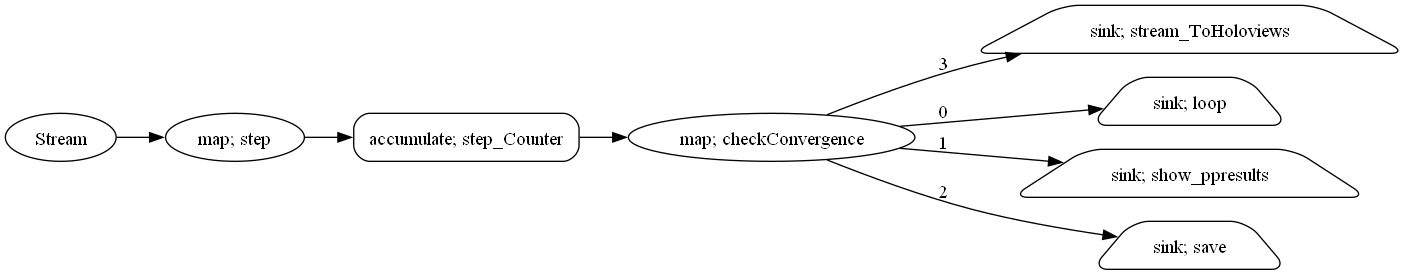

In [17]:
A = np.array([[12., 1., -1.],
              [20., 2.,  1.],
              [ 0., 0., 30.]])

pipeline = sz.Stream(loop=None)
pm_out   = pipeline.map(make_Step(A))\
              .accumulate( step_Counter, returns_state=True, start=0)\
              .map(make_ConvergenceCheck(50,tol=1e-6))
              #.rate_limit(0.5) #appears not to work in jupyter notebook :-(
pm_out.sink(make_LoopBack(50,pipeline));
pm_out.sink(show_ppresults);
save = make_SaveResults()
pm_out.sink(save);

eigenvalue_stream, evolution_plot = eigenvalue_plot()
pm_out.sink( make_StreamToHoloviews(eigenvalue_stream) );

display(pipeline.visualize(rankdir="LR"));

In [18]:
evolution_plot

:DynamicMap   []
   :Layout
      .Curve.Evolution_of_the_Eigenvalue :Curve   [iteration]   (eigenvalue)
      .Curve.Change_in_the_Eigenvector   :Curve   [iteration]   (diff_squared)

In [19]:
pipeline.emit(np.array([1.,2.,1.]))

 19:   [-0.0557 -0.0041  0.9984],  diff2: 7.503515e-13
 18:   [-0.0557 -0.0041  0.9984],  diff2: 3.5937365e-12
 17:   [-0.0557 -0.0041  0.9984],  diff2: 1.7211859e-11
 16:   [-0.0557 -0.0041  0.9984],  diff2: 8.2434603e-11
 15:   [-0.0557 -0.0041  0.9984],  diff2: 3.9481327e-10
 14:   [-0.0557 -0.0041  0.9984],  diff2: 1.8909275e-09
 13:   [-0.0557 -0.0041  0.9984],  diff2: 9.0564936e-09
 12:   [-0.0556 -0.0040  0.9984],  diff2: 4.3376028e-08
 11:   [-0.0555 -0.0038  0.9985],  diff2: 2.0775391e-07
 10:   [-0.0553 -0.0034  0.9985],  diff2: 9.9510593e-07
  9:   [-0.0548 -0.0025  0.9985],  diff2: 4.7668559e-06
  8:   [-0.0537 -0.0007  0.9986],  diff2: 2.283889e-05
  7:   [-0.0513  0.0035  0.9987],  diff2: 0.00010945395
  6:   [-0.0460  0.0125  0.9989],  diff2: 0.0005244913
  5:   [-0.0344  0.0323  0.9989],  diff2: 0.002504442
  4:   [-0.0091  0.0754  0.9971],  diff2: 0.011684946
  3:   [ 0.0457  0.1678  0.9848],  diff2: 0.048527749
  2:   [ 0.1551  0.3491  0.9242],  diff2: 0.1306964
  1: 

In [20]:
save.results[0]

{'e_val': np.float64(30.0000003765957),
 'e_vec': array([-0.05569768, -0.00412515,  0.99843916]),
 'diff2': np.float64(7.503515002659277e-13),
 'step_n': 19,
 'cnv_flag': 1}

In [21]:
df =pd.DataFrame(
    {'step_n': [i['step_n'] for i in save.results ],
     'e_val':  [i['e_val' ] for i in save.results ],
     'e_vec':  [i['e_vec' ] for i in save.results ],
     'diff2':  [i['diff2' ] for i in save.results ]})
df.head(3)

,step_n,e_val,e_vec,diff2
0,19,30.000000,"[-0.055697683761454876, -0.0041251523217902515...",7.503515e-13
1,18,30.000001,"[-0.05569724744632445, -0.004124404506134243, ...",3.593736e-12
2,17,30.000002,"[-0.05569629258330061, -0.004122767933472809, ...",1.721186e-11


## 3.2 Inverse Power Method

In [22]:
import scipy.linalg as sla

In [23]:
def inverse_power_method( A, x, n, plots, tol=1.e-10 ):
    plots.reset_plots()
    print( " Iteration\t\t x \t          y \t\t Change")

    lu = sla.lu_factor(A)

    for i in range(n):
        x_old = x
        x     = sla.lu_solve( lu, x)        # new_x = A^.inv x <=> solve A new_x = x
        x     = x / np.linalg.norm( x )

        err   = np.linalg.norm( x-x_old )

        print( f"{i:10}\t {x[0]: .10f}\t   {x[1]: .10f}\t{err: .10f}" )
        plots.monitor( [i, x[0], x[1], err] )

        if err < tol:
            return x, x.T @ A @ x   # return an eigenpair, lambda estimated using Rayleigh Coefficient

        time.sleep(0.3)
    return None

In [24]:
A = np.array([[12., 1., -1.],
              [20., 2.,  1.],
              [ 0., 0., 30.]])

plots = GraphicalMonitor2D(15,use_log=False)
Markdown('**<font size="5">Power Method**</font>')
plots.plots

inverse_power_method( A,
                np.array([1,1,1]),
                100,
                plots
              )

**<font size="5">Power Method**</font>

Column
    [0] Row
        [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', width=500)
        [1] HoloViews(DynamicMap, height=300, sizing_mode='fixed', width=300)
    [1] HoloViews(DynamicMap, height=450, width=500)

 Iteration		 x 	          y 		 Change
         0	  0.1204275302	   -0.9926147941	 2.3906442594
         1	  0.0858269940	   -0.9963100465	 0.0376829100
         2	  0.0851159003	   -0.9963710571	 0.0007261680
         3	  0.0851006929	   -0.9963723561	 0.0000153182
         4	  0.0851003683	   -0.9963723839	 0.0000003260
         5	  0.0851003614	   -0.9963723844	 0.0000000069
         6	  0.0851003613	   -0.9963723845	 0.0000000001
         7	  0.0851003613	   -0.9963723845	 0.0000000000


(array([ 8.51003613e-02, -9.96372384e-01,  1.14416451e-16]),
 np.float64(0.29179606749932996))

##### **Implementation using streamz**

In [25]:
def inverse_power_method_step( lu, x):
    '''implements a single step of the power method

    Args:
        A  : the np.array matrix
        x  : the current np.array unit vector

    Returns
        diff2, eigval_estimate, eigvec_estimate, where diff2 is the l2 norm of the change in the eigvec_estimate
    '''
    new_x        = sla.lu_solve( lu, x)   # new_x = A^.inv x <=> solve A new_x = x

    normalized_x = new_x / np.linalg.norm(new_x)
    diff         = normalized_x - x

    return normalized_x, diff @ diff

def make_InverseStep(A):
    def inverse_step(x):
        x,diff2 = inverse_power_method_step( inverse_step.lu, x )
        e_val   = estimate_eigenvalue( inverse_step.A, x)
        return { 'e_val': e_val, 'e_vec': x, 'diff2': diff2}
    inverse_step.lu = sla.lu_factor(A)
    inverse_step.A  = A
    return inverse_step

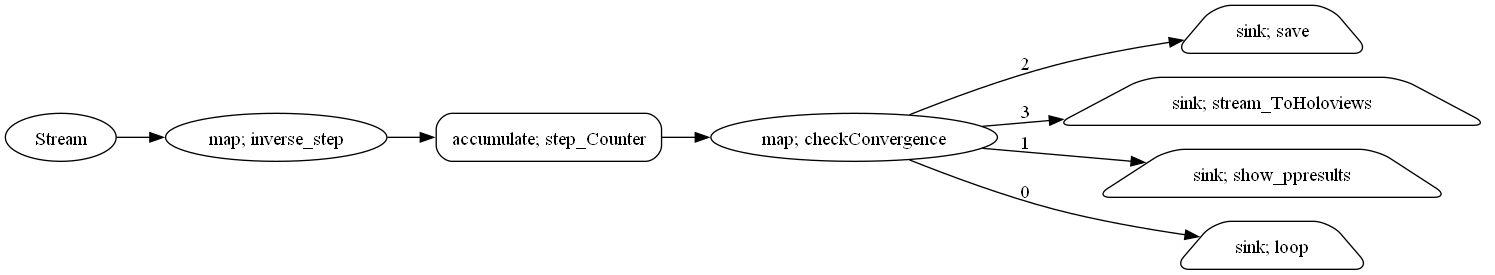

In [31]:
pipeline = sz.Stream(loop=None)
pm_out   = pipeline.map(make_InverseStep(A))\
              .accumulate( step_Counter, returns_state=True, start=0)\
              .map(make_ConvergenceCheck(50,tol=1e-8))
#              .rate_limit(0.5) appears not to work in jupyter notebook :-(
pm_out.sink(make_LoopBack(50,pipeline));
pm_out.sink(show_ppresults);
save = make_SaveResults()
pm_out.sink(save);

eigenvalue_stream, evolution_plot = eigenvalue_plot()
pm_out.sink( make_StreamToHoloviews(eigenvalue_stream) );

display(pipeline.visualize(rankdir="LR"));

In [32]:
evolution_plot

:DynamicMap   []
   :Layout
      .Curve.Evolution_of_the_Eigenvalue :Curve   [iteration]   (eigenvalue)
      .Curve.Change_in_the_Eigenvector   :Curve   [iteration]   (diff_squared)

In [33]:
pipeline.emit(np.array([1.,2.,1.]))

  7:   [-0.0851  0.9964  0.0000],  diff2: 4.0084593e-19
  6:   [-0.0851  0.9964  0.0000],  diff2: 8.8397091e-16
  5:   [-0.0851  0.9964  0.0000],  diff2: 1.9486514e-12
  4:   [-0.0851  0.9964  0.0000],  diff2: 4.3005096e-09
  3:   [-0.0850  0.9964  0.0000],  diff2: 9.5315537e-06
  2:   [-0.0820  0.9966  0.0005],  diff2: 0.015479265
  1:   [ 0.0340  0.9984  0.0454],  diff2: 2.8476063


# REDO

In [157]:
class GraphicalMonitor:
    """Class to visualize iterates and error evolution step-by-step, with a final table display."""

    @staticmethod
    def _table_formatter2D(plot, element):
        """Custom table formatter for styling."""
        plot.handles['table'].columns[3].formatter = HTMLTemplateFormatter(
            template="""<div style="color:red;"><%= value ? value.toExponential(8) : value %></div>"""
        )

    def __init__(self, buffer_size=10, log_y=True):
        """
        Initialize the graphical monitor.

        Parameters:
        - buffer_size: Maximum number of points to store in the buffer.
        """
        # Buffers for solution and error
        self.solution_buffer = Buffer(pd.DataFrame({'x': [], 'y': []}), length=buffer_size)
        self.error_buffer = Buffer(pd.DataFrame({'step': [], 'error': []}), length=buffer_size)

        # Store results in a DataFrame
        self.results = pd.DataFrame(
            {'step': pd.Series(dtype='int'),
             'x': pd.Series(dtype='float'),
             'y': pd.Series(dtype='float'),
             'error': pd.Series(dtype='float')}
        )

        # Panel table for displaying results
        self.results_table = pn.panel(hv.Table(self.results.tail(10)).opts(  # Show the latest rows
            height=150,  # Adjusted height to show limited rows
            width=800,   # Adjusted width to match the updated plot sizes
            hooks=[self._table_formatter2D]  # Apply custom formatting
        ))

        # Create DynamicMaps for solution and error plots
        self.solution_plot = hv.DynamicMap(self._plot_solution, streams=[self.solution_buffer])
        self.error_plot = hv.DynamicMap(self._plot_error, streams=[self.error_buffer])

        # Combine the plots and the table in a layout
        self.plot = pn.Column(
            pn.Row(
                self.solution_plot.opts(width=400, height=400),
                self.error_plot.opts(width=400, height=400),
            ),
            pn.Row( self.results_table, width=800)  # Include the dynamically updated table
        )
        self.logy_error( log_y)

    def logy_error(self, log_y=True):
        self.error_plot.opts(logy=log_y) 

    def _plot_solution(self, data):
        """Plot the solution as a styled scatter and curve, highlighting the final point."""
        curve = hv.Curve(data, "x", "y").opts(line_width=2, color="darkblue")
        scatter = hv.Scatter(data, "x", "y").opts(size=8, color="blue", tools=["hover"])

        if not data.empty:  # Highlight the most recent (last) point
            last_point = hv.Scatter(data.iloc[-1:], "x", "y").opts(size=10, color="red")
            scatter = scatter * last_point

        return scatter * curve.opts(
           title="Solution Estimate", show_grid=True
        )

    def _plot_error(self, data):
        """Plot the error evolution with styled curve."""
        curve = hv.Curve(data, "step", "error").opts(
            title="Error Evolution", color="red", line_width=2, show_grid=True
        )
        return curve

    def update_solution(self, x, y):
        """Update the solution plot with a new (x, y) point."""
        df = pd.DataFrame({'x': [x], 'y': [y]})
        self.solution_buffer.send(df)  # Send new data to the buffer

    def update_error(self, step, error):
        """Update the error plot with a new (step, error) point."""
        df = pd.DataFrame({'step': [step], 'error': [error]})
        self.error_buffer.send(df)  # Send new data to the buffer

    def add_result(self, step, x, y, error):
        """Add a result to the results DataFrame and refresh the table."""
        # Add new data to the DataFrame
        new_row = pd.DataFrame({'step': [step], 'x': [x], 'y': [y], 'error': [error]})
        self.results = pd.concat([self.results, new_row], ignore_index=True)

        # Refresh the hv.Table with the latest rows of the DataFrame
        self.results_table.object = hv.Table(self.results.tail(10)).opts(  # Show the latest rows
            height=150,
            width=800,
            hooks=[self._table_formatter2D]
        )


    def producer(self, func, x_initial, n, tol):
        """
        Generic iterative producer function for an iterative scheme

        Parameters:
        - func: A callable that computes the next step, given (step, x).
        - x_initial: Initial guess for the solution.
        - n: Maximum number of iterations.
        - tol: Convergence tolerance.
        """
        x = x_initial.copy()
        for step in range(n):
            x_new, error = func(x)                            # Compute the next step and error
            self.update_solution(x_new[0], x_new[1])          # Update solution plot
            self.update_error(step, error)                    # Update error plot
            self.add_result(step, x_new[0], x_new[1], error)  # Add result to the table

            print(f"Step {step:3d}: x = ({x_new[0]:.6f}, {x_new[1]:.6f}, error = {error:18.10f}")  # Debugging output
            x = x_new

            if error < tol:
                print(f"Converged at step {step}")
                break

            time.sleep(0.5)  # Simulate computation delay

    def run(self, func, x_initial, n, tol):
        """
        Run the iterative process in a separate thread.

        Parameters:
        - func: The function that computes a single iteration.
        - x_initial: Initial guess for the solution.
        - n: Maximum number of iterations.
        - tol: Convergence tolerance.
        """
        thread = threading.Thread(target=self.producer, args=(func, x_initial, n, tol))
        thread.start()

In [113]:
def mk_custom_step(S, T, b):
    def solve_S(mat):  return solve(S, mat)
    
    SinvT = solve_S(T)
    Sinvb = solve_S(b)

    def custom_step(x):
        """
        Compute the next step of the Jacobi iterative scheme.
        
        Parameters:
        - x: Current solution vector.

        Returns:
        - x_new: Updated solution vector.
        - error: Error of the update.
        """
        x_new = SinvT @ x + Sinvb  # Jacobi iteration formula
        error = np.linalg.norm(x_new - x)  # Compute the error norm
        return x_new, error

    return custom_step


In [158]:
# Jacobi Method
A = np.array([[6., .1], [-.2, .9]])
b = np.array([0.8,1.6])

S = np.diag( np.diag(A) )
T = S - A
custom_step = mk_custom_step(S, T, b)

# Initialize the graphical monitor
monitor = GraphicalMonitor(buffer_size=20, log_y=True)
monitor.plot

Column
    [0] Row
        [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=400)
        [1] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=400)
    [1] Row(width=800)
        [0] HoloViews(Table, height=150, width=800)

In [159]:
# Run the Jacobi producer in a separate thread
monitor.run(custom_step, x_initial=np.array([0., 0.]), n=50, tol=1e-8)

Step   0: x = (0.133333, 1.777778, error =       1.7827707662
Step   1: x = (0.103704, 1.807407, error =       0.0419026241
Step   2: x = (0.103210, 1.800823, error =       0.0066028547
Step   3: x = (0.103320, 1.800713, error =       0.0001551949
Step   4: x = (0.103321, 1.800738, error =       0.0000244550
Step   5: x = (0.103321, 1.800738, error =       0.0000005748
Step   6: x = (0.103321, 1.800738, error =       0.0000000906
Step   7: x = (0.103321, 1.800738, error =       0.0000000021
Converged at step 7


In [109]:
step=3; x_new,error=custom_step(np.array([1,3]))

In [111]:
print(f"Step {step:3d}: x = ({x_new[0]:.6f}, {{x_new[1]:.6f}}, error = {error:.6g}")  # Debugging output


Step   3: x = (0.083333, {x_new[1]:.6f}, error = 1.35657
